In [7]:
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

2.1.0


In [8]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,)
    plt.show()

In [9]:
dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/'
data = torch.load(dir+'trainset/graphs/event000000053-graph.pyg')

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Has isolated nodes: {data.has_isolated_nodes()}')
#print(f'Has self-loops: {data.has_self_loops()}')
#print(f'Is undirected: {data.is_undirected()}')

Data(x=[6, 4], edge_index=[2, 5], y=[6, 4])
Number of nodes: 6
Number of edges: 5
Average node degree: 0.83


In [10]:
import pandas as pd

# Sample data
data = {
    'particle_id': [1, 1, 1, 1, 1, 1, 1, 1, 3, 3],
    'layer': ['3', '2', '1', '0', '0', '1', '2', '3', '3', '3'],
    'station': ['0', '0', '0', '0', '0', '0', '0', '0', '-1', '-1'],
    'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'other stuff': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
}

signal = pd.DataFrame(data)
module_columns = ['layer', 'station']

# Grouping and aggregating
grouped = signal.groupby(['particle_id'] + module_columns, sort=False)['index'].agg(lambda x: list(x))
print(grouped)
print('===================')


grouped_again = grouped.groupby(level=0).agg(lambda x: list(x))
print(grouped_again)
print('===================')

signal_index_list = (grouped_again)
print(signal_index_list)
print('===================')

print(signal_index_list.values)

row = signal_index_list.values[1]
print(row[:-1])
print(row[1:])
print('===================')

from itertools import product
track_index_edges = []
for row in signal_index_list.values:
        
        for i, j in zip(row[:-1], row[1:]):
            track_index_edges.extend(list(product(i, j)))   

print(track_index_edges)

particle_id  layer  station
1            3      0          [0, 7]
             2      0          [1, 6]
             1      0          [2, 5]
             0      0          [3, 4]
3            3      -1         [8, 9]
Name: index, dtype: object
particle_id
1    [[0, 7], [1, 6], [2, 5], [3, 4]]
3                            [[8, 9]]
Name: index, dtype: object
particle_id
1    [[0, 7], [1, 6], [2, 5], [3, 4]]
3                            [[8, 9]]
Name: index, dtype: object
[list([[0, 7], [1, 6], [2, 5], [3, 4]]) list([[8, 9]])]
[]
[]
[(0, 1), (0, 6), (7, 1), (7, 6), (1, 2), (1, 5), (6, 2), (6, 5), (2, 3), (2, 4), (5, 3), (5, 4)]


In [11]:
import pandas as pd
import numpy as np
from itertools import product
import torch
from torch_geometric.data import Data

dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/'
example_event = pd.read_csv(dir+'trainset/csv/event000000002-truth.csv')

def process_hits(hits):
        #Rename tid and layer
        hits = hits.rename(columns={'tid': 'particle_id'})
        hits = hits.rename(columns={'layer': 'layer_id'})

        # Calculate the pT of the particle
        hits['pt'] = np.sqrt(hits["px"] ** 2 + hits["py"] ** 2)

        # Calculate the radius of the particle
        hits['radius'] = np.sqrt(hits["vx"] ** 2 + hits["vy"] ** 2)

        #Assign nhits
        hits['nhits'] = len(hits['x'])

        # Assign hit_ids
        hits['hit_id'] = list(range(1,len(hits['x'])+1))

        #Assign station_id: -1 for upstream recoil, 0 for central and +1 for downstream recurl station
        conditions = [(hits['z'] < -200), (hits['z'] < 200), (hits['z'] >= 200)]
        ids = [-1, 0, 1]
        hits['station_id'] = np.select(conditions, ids)

        #Assign ladder_id:
        hits['ladder_id'] = list(range(1,len(hits['x'])+1))
    
        return hits

def remap_edges(track_edges, track_features, hits):
        """
        Here we do two things:
        1. Remove duplicate hits from the hit list (since a hit is a node and therefore only exists once), and remap the corresponding truth track edge indices
        2. Remove duplicate truth track edges. This is a SMALL simplification for conceptual simplicity,
        but we apply a test to ensure the simplification does not throw away too many duplicate edges.
        """

        unique_hid = np.unique(hits.hit_id)
        hid_mapping = np.zeros(unique_hid.max() + 1).astype(int)
        hid_mapping[unique_hid] = np.arange(len(unique_hid))

        hits = hits.drop_duplicates(subset="hit_id").sort_values("hit_id")

        track_edges = hid_mapping[track_edges]

        # Remove duplicate edges
        unique_track_edges, unique_track_edge_indices = np.unique(
            track_edges, axis=1, return_index=True
        )
        track_features = {
            k: v[unique_track_edge_indices] for k, v in track_features.items()
        }

        # This test imposes a limit to how we simplify the graph: We don't allow shared EDGES (i.e. two different particles can share a hit, but not an edge between the same two hits). We want to ensure these are in a tiny minority
        n_shared_edges = track_edges.shape[1] - unique_track_edges.shape[1]
        assert n_shared_edges < 50, "The number of shared EDGES is unusually high!"

        return unique_track_edges, track_features, hits

def build_graph(self, hits, tracks, track_features, event_id):
        """
        Builds a PyG data object from the hits, particles and tracks.
        """

        graph = Data()
        for feature in set(self.config["feature_sets"]["hit_features"]).intersection(
            set(hits.columns)
        ):
            graph[feature] = torch.from_numpy(hits[feature].values)

        graph.track_edges = torch.from_numpy(tracks)
        for feature in set(self.config["feature_sets"]["track_features"]).intersection(
            set(track_features.keys())
        ):
            graph[feature] = torch.from_numpy(track_features[feature])

        # Add config dictionary to the graph object, so every data has a record of how it was built
        graph.config = [self.config]
        graph.event_id = str(event_id)

        return graph

In [12]:
print('=====Raw hit data=====')
print(example_event)
print('==========================')

hits = process_hits(example_event)

print('=====Hit data after process_hits=====')
print(hits)
print('================')

hits = hits.assign(
            R=np.sqrt(
                (hits.x - hits.vx) ** 2
                + (hits.y - hits.vy) ** 2
                + (hits.z - hits.vz) ** 2
            )
        )

signal = hits[(hits.particle_id != 0)]
signal = signal.sort_values("R").reset_index(drop=False)

print()
print('=====Hit data after sorting by R=====')
print(signal)
print('===================')

=====Raw hit data=====
   event  layer  ladder  module  station          x          y           z  \
0      2      2       2       0        2 -50.322186  52.171955  354.160004   
1      2      2       4       1        2 -68.043694  23.938395  346.179993   
2      2      3       1       0        2 -33.974640  78.191750  361.470001   
3      2      3       7       1        2 -85.161835  -3.560488  338.470001   

            px           py          pz          vx          vy         vz  \
0 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   
1 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   
2 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   
3 -2334.052246 -3342.965576 -956.682495  452.045044  798.244934  567.13269   

   pid    tid  mid  
0  -13  41880    0  
1  -13  41880    0  
2  -13  41880    0  
3  -13  41880    0  
=====Hit data after process_hits=====
   event  layer_id  ladder  module  station         

In [13]:
module_columns = ['layer_id', 'station_id', 'ladder_id']

signal_index_list = (
            signal.groupby(
                ["particle_id"] + module_columns,
                sort=False,
            )["index"]
            .agg(lambda x: list(x))
            .groupby(level=0)
            .agg(lambda x: list(x))
        )
print('=====signal_index_list after grouping and aggregating=====')
print(signal_index_list)
print('==================')

track_index_edges = []
for row in signal_index_list.values:
    for i, j in zip(row[:-1], row[1:]):
        track_index_edges.extend(list(product(i, j)))

print()
print('=====track_index_edges=====')
print(track_index_edges)
print(np.array(track_index_edges).T)
print('===============')

track_index_edges = np.array(track_index_edges).T

'''
track_edges = hits.hit_id.values[track_index_edges]


print()
print('======Track edges=====')
print(track_edges)
print('==================')
'''
track_features = {}

for track_feature in set(['particle_id', 'pt', 'radius', 'nhits']).intersection(set(hits.columns)):
    track_features[track_feature] = hits[track_feature].values[track_index_edges[0]]

print()
print('=====Track features======')
print(track_features)
print('===================')

'''
track_edges, track_features, hits = remap_edges(track_edges, track_features, hits)

print()
print('=====Track edges (remapped)=====')
print(track_edges)
print('=======================')
'''


=====signal_index_list after grouping and aggregating=====
particle_id
41880    [[2], [0], [1], [3]]
Name: index, dtype: object

=====track_index_edges=====
[(2, 0), (0, 1), (1, 3)]
[[2 0 1]
 [0 1 3]]

=====Track features======
{'radius': array([917.35472776, 917.35472776, 917.35472776]), 'pt': array([4077.1581685, 4077.1581685, 4077.1581685]), 'nhits': array([4, 4, 4]), 'particle_id': array([41880, 41880, 41880])}


"\ntrack_edges, track_features, hits = remap_edges(track_edges, track_features, hits)\n\nprint()\nprint('=====Track edges (remapped)=====')\nprint(track_edges)\nprint('=======================')\n"

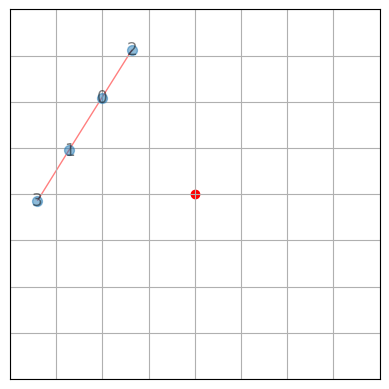

Number of nodes: 4
Number of edges: 3
Average node degree: 0.75
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Edges: [[2 0 1]
 [0 1 3]]


In [19]:
from torch_geometric import utils
import networkx as nx
graph = Data()

#Create feature_matrix: shape(num_nodes, num_node_features)
feature_matrix = torch.from_numpy(hits[['hit_id', 'x', 'y', 'z']].values)
edge_index = torch.from_numpy(track_index_edges)
graph_features = torch.from_numpy(hits[['particle_id', 'pt', 'radius', 'nhits']].values)

graph.x = feature_matrix
graph.edge_index = edge_index
graph.y = graph_features

def visualize_mu3e_graph(graph, hits):
    g = utils.to_networkx(graph, to_undirected=True)
    pos = hits[['x', 'y']].T.to_dict()

    pos = {node_num: np.array([value['x'], value['y']]) for node_num, value in pos.items()}
    
    plt.axes().set_aspect('equal')
    plt.scatter(x=0,y=0, color='red')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    nx.draw_networkx(g, pos=pos, node_size=300, with_labels=True, edge_color="r", alpha=0.5)

    plt.grid()
    plt.show()

    print(f'Number of nodes: {graph.num_nodes}')
    print(f'Number of edges: {graph.num_edges}')
    print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}') 
    print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
    print(f'Has self-loops: {graph.has_self_loops()}')
    print(f'Is undirected: {graph.is_undirected()}')
    print('Edges:',track_index_edges)

visualize_mu3e_graph(graph, hits)

Visualization 


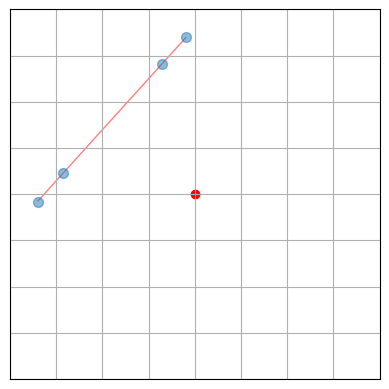

Number of nodes: 4
Number of edges: 3
Average node degree: 0.75
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Edges: [[2 0 1]
 [0 1 3]]


In [18]:
dir = '/mnt/data1/karres/cosmics_test/feature_store_cosmic/'
data = torch.load(dir+'trainset/graphs/event000013032-graph.pyg')
raw_hits = pd.read_csv(dir+'trainset/csv/event000013032-truth.csv')
print('Visualization ')
visualize_mu3e_graph(data, raw_hits)
#Graph created without ladder id -> too many edges

In [16]:
data = {
    'data1': [3,12,5,1,5,7,1],
    'data2': [45,2,8,2,31,8,5]
}

dataframe = pd.DataFrame(data)

dataframe = dataframe.sort_values("data1").reset_index(drop=False)
print(dataframe)

   index  data1  data2
0      3      1      2
1      6      1      5
2      0      3     45
3      2      5      8
4      4      5     31
5      5      7      8
6      1     12      2


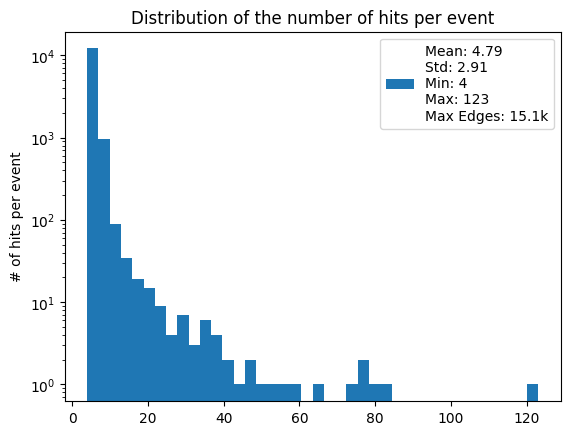

Event with most hits: 1208
Event with least hits: 18519


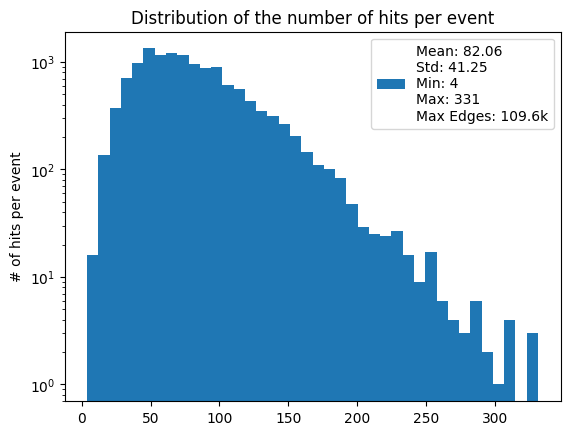

Event with most hits: 13584
Event with least hits: 14658


In [17]:
import matplotlib.pyplot as plt 

def event_histogram(dataframe):
    event_count = dataframe['event'].value_counts()

    plt.hist(event_count.tolist(), bins=40)
    plt.ylabel('# of hits per event')
    plt.yscale('log')
    plt.title('Distribution of the number of hits per event')

    # Calculate statistics
    mean = np.mean(event_count)
    std = np.std(event_count)
    min_val = np.min(event_count)
    max_val = np.max(event_count)

    # Create legend
    legend_text = f"Mean: {mean:.2f}\nStd: {std:.2f}\nMin: {min_val}\nMax: {max_val}"
    max_edges = max_val ** 2
    legend_text += f"\nMax Edges: {round(max_edges/1000,1)}k"
    plt.legend([legend_text])

    plt.show()

dir1 = '/mnt/data1/karres/cosmics_test/cosmics_data/cosmic_f1.csv'
dir2 = '/mnt/data1/karres/cosmics_test/cosmics_data/cosmic_michel_f2.csv'

cosmic = pd.read_csv(dir1)
michel = pd.read_csv(dir2)

event_histogram(cosmic)
print('Event with most hits:', cosmic['event'].value_counts().idxmax())
print('Event with least hits:', cosmic['event'].value_counts().idxmin())
print('========================================================================')
event_histogram(michel)
print('Event with most hits:', michel['event'].value_counts().idxmax())
print('Event with least hits:', michel['event'].value_counts().idxmin())
